In [5]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
%matplotlib inline
import utils

import os
from os.path import join as pjoin
import sys
import copy
import random
print(tf.__version__)

1.14.0


In [118]:
down_dir = './../data/train/down'
up_dir = './../data/train/up'
test_dir = './../data/test'

train_down = ['./../data/train/down/{}'.format(i) for i in os.listdir(down_dir)] # get hands down images
train_up = ['./../data/train/up/{}'.format(i) for i in os.listdir(up_dir)]       # get hands up images

test_imgs = ['./../data/test/{}'.format(i) for i in os.listdir(test_dir)]        # get test images

train_imgs = train_down + train_up
random.shuffle(train_imgs)

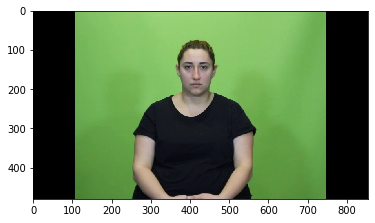

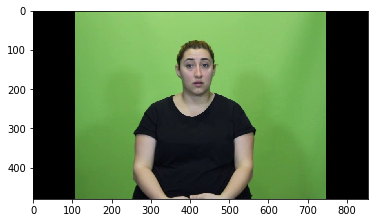

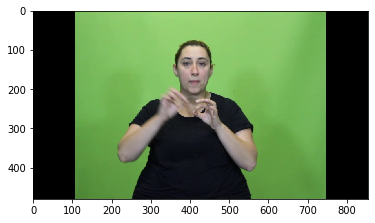

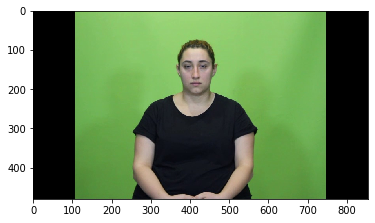

In [63]:
import matplotlib.image as mpimg
for ima in train_imgs[12:16]:
    img = mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [64]:
nrows = 150
ncolumns = 150
channels = 3

In [72]:
# A function to read and process the images an acceptable format for our model
# Returns two arrays: X -> resized images, y -> labels
def read_and_process_image(list_of_images):

    x = []
    y = []
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC)) # Read the image
        if 'down' in image:
            y.append(1)
        elif 'up' in image:
            y.append(0)
    
    return x,y

In [73]:
x,y = read_and_process_image(train_imgs)

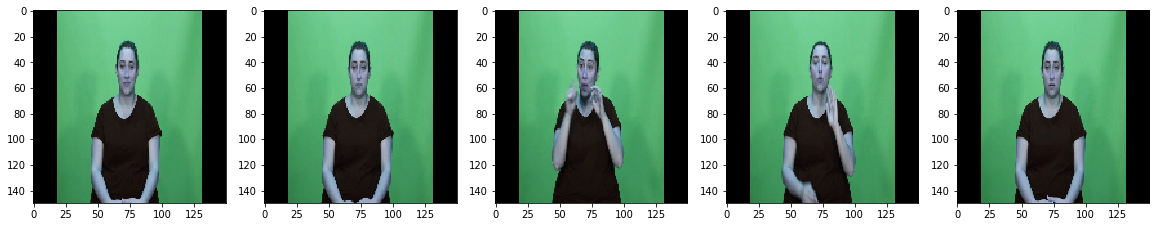

In [76]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns+1, columns, i+1)
    plt.imshow(x[i])

Text(0.5, 1.0, 'Labels for up and downs')

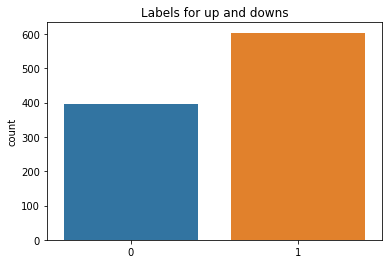

In [78]:
import seaborn as sns

x = np.array(x)
y = np.array(y)

sns.countplot(y)
plt.title('Labels for up and downs')

In [79]:
print("Shape of train images is:", x.shape)
print("Shape of labels is",y.shape)

Shape of train images is: (999, 150, 150, 3)
Shape of labels is (999,)


In [80]:
# Split the data into train and test set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.20, random_state=2)
print("Shape of train images is:",x_train.shape)
print("Shape of validation images is:",x_val.shape)
print("Shape of labels is:",y_train.shape)
print("Shape of label val is:",y_val.shape)

Shape of train images is: (799, 150, 150, 3)
Shape of validation images is: (200, 150, 150, 3)
Shape of labels is: (799,)
Shape of label val is: (200,)


In [81]:
#get the length of the train and validation data
ntrain = len(x_train)
nval = len(x_val)

batch_size = 32

In [84]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [86]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid')) # sigmoid at the end because we have just two classes

In [87]:
#Lets see our model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [91]:
# use RMSprop optimizer with a learning rate of 0.0001
# use binary_crossentropy loss because it is a binary classification
model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [92]:
# create the augmentatino configuration
# this helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255, #Scale the image between 0 and 1
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,)
val_datagen = ImageDataGenerator(rescale=1./255) # We do not augment validation data. we only perform rescale

In [98]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

In [100]:
# Training Part
history = model.fit_generator(train_generator,
                             steps_per_epoch = ntrain // batch_size,
                             epochs=64,
                             validation_data = val_generator,
                             validation_steps=nval // batch_size)

Epoch 1/64
24/24 [==============================] - 23s 978ms/step - loss: 0.0968 - acc: 0.9778 - val_loss: 9.3349e-04 - val_acc: 0.9740
Epoch 2/64
24/24 [==============================] - 23s 977ms/step - loss: 0.0765 - acc: 0.9778 - val_loss: 0.0175 - val_acc: 0.9821
Epoch 3/64
24/24 [==============================] - 23s 966ms/step - loss: 0.0712 - acc: 0.9726 - val_loss: 0.1431 - val_acc: 0.9821
Epoch 4/64
24/24 [==============================] - 23s 967ms/step - loss: 0.0858 - acc: 0.9674 - val_loss: 0.0020 - val_acc: 0.9762
Epoch 5/64
24/24 [==============================] - 24s 987ms/step - loss: 0.1055 - acc: 0.9726 - val_loss: 0.1912 - val_acc: 0.9702
Epoch 6/64
24/24 [==============================] - 23s 969ms/step - loss: 0.0819 - acc: 0.9727 - val_loss: 0.0017 - val_acc: 0.9821
Epoch 7/64
24/24 [==============================] - 23s 967ms/step - loss: 0.0956 - acc: 0.9700 - val_loss: 0.0048 - val_acc: 0.9702
Epoch 8/64
24/24 [==============================] - 24s 991ms/ste

24/24 [==============================] - 23s 960ms/step - loss: 0.0891 - acc: 0.9817 - val_loss: 0.1751 - val_acc: 0.9821
Epoch 63/64
24/24 [==============================] - 23s 956ms/step - loss: 0.0995 - acc: 0.9701 - val_loss: 4.7550e-04 - val_acc: 0.9762
Epoch 64/64
24/24 [==============================] - 23s 972ms/step - loss: 0.0562 - acc: 0.9831 - val_loss: 5.0101e-04 - val_acc: 0.9740


In [101]:
# Save the model

model.save_weights('model_weights.h5')
model.save('model_keras.h5')

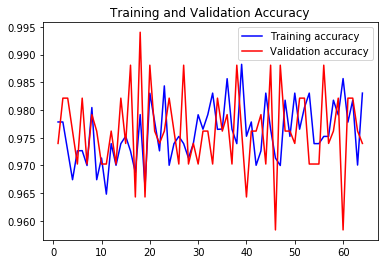

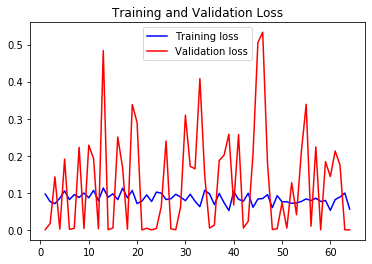

In [103]:
# plot the train and val curve

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure();
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [114]:
# Now lets predict on the first 10 Images of the test set
x_test, y_test = read_and_process_image(test_imgs)
x = np.array(x_test)
test_datagen = ImageDataGenerator(rescale=1./255)

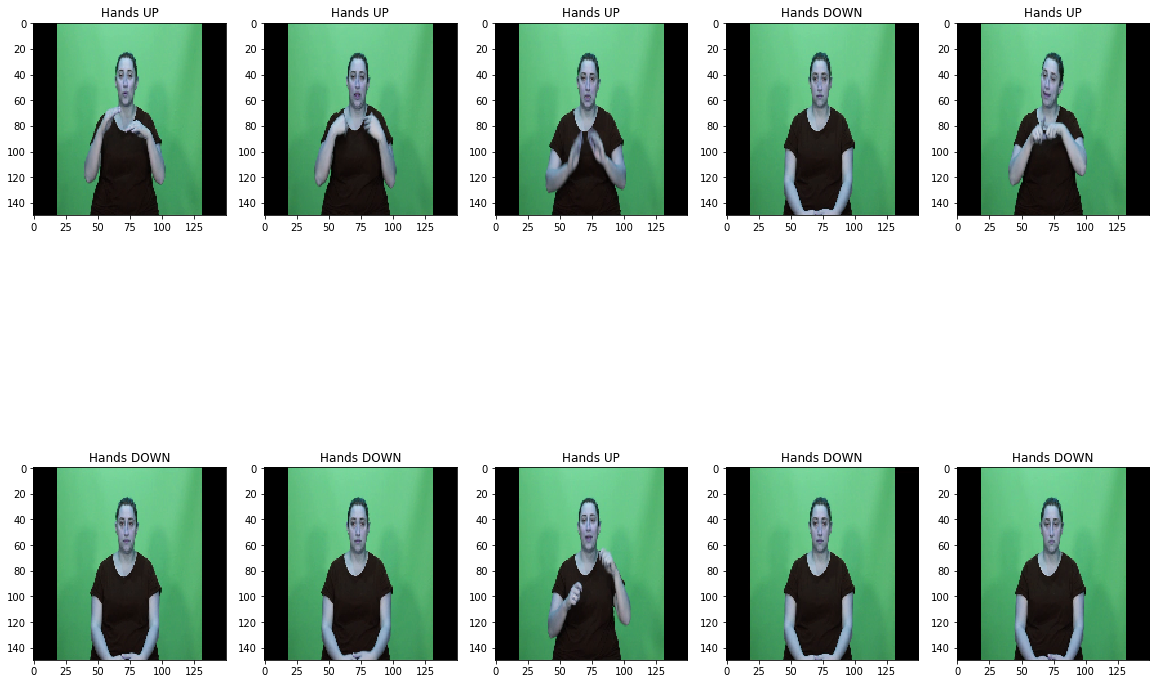

In [117]:
i = 0
text_labels = []
plt.figure(figsize=(20,15))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('DOWN')
    else:
        text_labels.append('UP')
        
    plt.subplot(5/columns+1, columns, i+1)
    plt.title('Hands '+text_labels[i])
    imgplot = plt.imshow(batch[0])
    i+=1
    if i%10 == 0:
        break

plt.show()